In [1]:
import os, sys, time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import preprocessing
from sklearn.svm import LinearSVC
from scipy import stats
from collections import defaultdict
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
import transformers
from transformers import BertForSequenceClassification
from ipywidgets import FloatProgress
import torch
from transformers import BertModel
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [2]:
data_folder=os.getcwd()
test_set="book30-listing-test.csv"
train_set="book30-listing-train.csv"

test=pd.read_csv(os.path.join(data_folder+"/"+test_set), sep=",", encoding='latin_1') #'unicode_escape'
train=pd.read_csv(os.path.join(data_folder+"/"+train_set), sep=",", encoding='latin_1')
#setting up columns' names
test=test.set_axis(["AMAZON INDEX (ASIN)","FILENAME","IMAGE URL","TITLE","AUTHOR","CATEGORY ID","CATEGORY"], axis=1, inplace=False)
train=train.set_axis(["AMAZON INDEX (ASIN)","FILENAME","IMAGE URL","TITLE","AUTHOR","CATEGORY ID","CATEGORY"], axis=1, inplace=False)

#selecting title and category id
test_set = test[['TITLE','CATEGORY ID', "CATEGORY"]]
train_set = train[['TITLE','CATEGORY ID', 'CATEGORY']]



Train set: \n Children's Books                1710
Engineering & Transportation    1710
Science Fiction & Fantasy       1710
Calendars                       1710
Self-Help                       1710
Teen & Young Adult              1710
Reference                       1710
Comics & Graphic Novels         1710
History                         1710
Romance                         1710
Parenting & Relationships       1710
Arts & Photography              1710
Test Preparation                1710
Computers & Technology          1710
Law                             1710
Humor & Entertainment           1710
Literature & Fiction            1710
Religion & Spirituality         1710
Crafts, Hobbies & Home          1710
Politics & Social Sciences      1710
Cookbooks, Food & Wine          1710
Business & Money                1710
Travel                          1710
Science & Math                  1710
Medical Books                   1710
Health, Fitness & Dieting       1710
Sports & Outdoors       

Text(0.5,0,'categories')

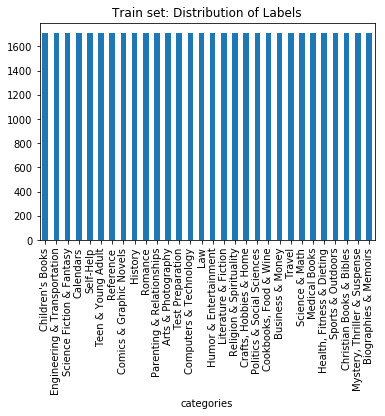

In [3]:
print('Train set:','\\n', train_set['CATEGORY'].value_counts())
train_set['CATEGORY'].value_counts().plot.bar()
plt.title('Train set: Distribution of Labels')
plt.xlabel('categories')

Train set: \n 4     1710
10    1710
24    1710
3     1710
25    1710
27    1710
20    1710
5     1710
12    1710
22    1710
18    1710
0     1710
28    1710
6     1710
14    1710
13    1710
15    1710
21    1710
8     1710
19    1710
7     1710
2     1710
29    1710
23    1710
16    1710
11    1710
26    1710
9     1710
17    1710
1     1709
Name: CATEGORY ID, dtype: int64


Text(0.5,0,'categories')

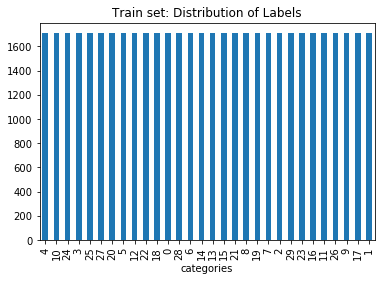

In [4]:
print('Train set:','\\n', train_set['CATEGORY ID'].value_counts())
train_set['CATEGORY ID'].value_counts().plot.bar()
plt.title('Train set: Distribution of Labels')
plt.xlabel('categories')

Test set: \n 28    190
1     190
17    190
24    190
22    190
27    190
5     190
12    190
3     190
20    190
13    190
29    190
8     190
7     190
6     190
26    190
18    190
2     190
11    190
19    190
14    190
25    190
4     190
9     190
23    190
10    190
15    190
0     190
21    190
16    189
Name: CATEGORY ID, dtype: int64


Text(0.5,0,'categories')

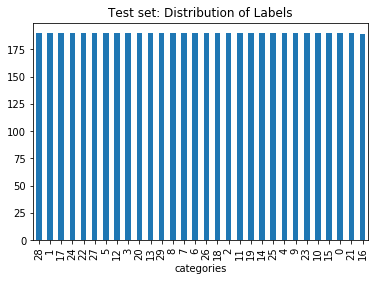

In [6]:
print('Test set:','\\n', test_set['CATEGORY ID'].value_counts())
test_set['CATEGORY ID'].value_counts().plot.bar()
plt.title('Test set: Distribution of Labels')
plt.xlabel('categories')

In [5]:
length = len(train_set) + len(test_set)

print(0.8*length, 0.1* length, 0.1*length)
train_set = train_set.sample(frac=1).reset_index(drop=True)

train_s=train_set[:45598]
val_s=train_set[45598:] 

print(f'LENGTH OF VALIDATION SET: {len(val_s)}, \
      LENGTH OF TEST SET: {len(test_set)},  \
      LENGTH OF TRAIN SET: {len(train_s)}. ')


45598.4 5699.8 5699.8
LENGTH OF VALIDATION SET: 5701,       LENGTH OF TEST SET: 5699,        LENGTH OF TRAIN SET: 45598. 


In [6]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased',
                                         do_lower_case=True)

#checking for the longest title -> we want to set padding to max_length instead of 512
length_of_the_messages_test = test_set['TITLE'].str.split("\\s+")
length_of_the_messages_train = train_set['TITLE'].str.split("\\s+")

print(f"Max number of words in test_set: {length_of_the_messages_test.str.len().max()}")
print(f"Max number of words in train_set: {length_of_the_messages_train.str.len().max()}")
print("Index = ", length_of_the_messages_train.str.len().idxmax())

Max number of words in test_set: 53
Max number of words in train_set: 74
Index =  23983


In [7]:
print(length_of_the_messages_train[23983])

['[', 'Antidiabetic', 'Agents:', 'Recent', 'Advances', 'in', 'Their', 'Molecular', 'and', 'Clinical', 'Pharmacology', '[', 'ANTIDIABETIC', 'AGENTS:', 'RECENT', 'ADVANCES', 'IN', 'THEIR', 'MOLECULAR', 'AND', 'CLINICAL', 'PHARMACOLOGY', 'BY', 'Testa', '-.', 'Meyer,', '-.', 'Meyer', '(', 'Author', ')', 'May-28-1996[', 'ANTIDIABETIC', 'AGENTS:', 'RECENT', 'ADVANCES', 'IN', 'THEIR', 'MOLECULAR', 'AND', 'CLINICAL', 'PHARMACOLOGY', '[', 'ANTIDIABETIC', 'AGENTS:', 'RECENT', 'ADVANCES', 'IN', 'THEIR', 'MOLECULAR', 'AND', 'CLINICAL', 'PHARMACOLOGY', 'BY', 'TESTA', '-.', 'MEYER,', '-.', 'MEYER', '(', 'AUTHOR', ')', 'MAY-28-1996', ']', 'By', 'Testa', '-.', 'Meyer,', '-.', 'Meyer', '(', 'Author', ')May-28-1996', 'Hardcover']


In [7]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, X):

        self.labels = [label for label in X['CATEGORY ID']]  #list
        self.texts = [tokenizer(title, truncation=True, padding='max_length', max_length = 74,  
                    return_tensors="pt") for title in X['TITLE']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y


In [8]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased', num_labels=30) #bert-base-multilingual-cased
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 30) 
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)
        

        return final_layer



## Training

In [13]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True) #2
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=1) #2
    

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")


    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:
            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()

                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')


In [8]:
#Hyperparameters      
EPOCHS = 5
model = BertClassifier()
LR = 1e-6            
train(model, train_s, val_s, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|█████████████████████████████████████████████████████████████████████████████| 45598/45598 [47:24<00:00, 16.03it/s]


Epochs: 1 | Train Loss:  2.568                 | Train Accuracy:  0.343                 | Val Loss:  2.238                 | Val Accuracy:  0.384


100%|█████████████████████████████████████████████████████████████████████████████| 45598/45598 [48:15<00:00, 15.75it/s]


Epochs: 2 | Train Loss:  1.695                 | Train Accuracy:  0.561                 | Val Loss:  1.755                 | Val Accuracy:  0.518


100%|█████████████████████████████████████████████████████████████████████████████| 45598/45598 [47:28<00:00, 16.01it/s]


Epochs: 3 | Train Loss:  1.355                 | Train Accuracy:  0.647                 | Val Loss:  1.666                 | Val Accuracy:  0.549


100%|█████████████████████████████████████████████████████████████████████████████| 45598/45598 [47:43<00:00, 15.92it/s]


Epochs: 4 | Train Loss:  1.083                 | Train Accuracy:  0.725                 | Val Loss:  1.611                 | Val Accuracy:  0.572


100%|█████████████████████████████████████████████████████████████████████████████| 45598/45598 [48:11<00:00, 15.77it/s]


Epochs: 5 | Train Loss:  0.821                 | Train Accuracy:  0.798                 | Val Loss:  1.633                 | Val Accuracy:  0.573


### Evaluation

In [ ]:
def evaluate(model, test_data):
    
    y_pred = []
    y_true = []

    test = Dataset(test_data)
    model = model.eval()

    test_loader = torch.utils.data.DataLoader(test, batch_size=100,shuffle=False)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_loader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            
            y_pred.extend(output.argmax(dim=1).data.cpu().numpy())
            y_true.extend(test_label.data.cpu().numpy())

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

    
    # constant for classes
    classes = ('Arts & Photography', 'Biographies & Memoirs', 'Business & Money', 'Calendars', "Children's Books", 'Christian Books & Bibles', 'Comics & Graphic Novels', 'Computers & Technology', 'Cookbooks, Food & Wine', 'Crafts, Hobbies & Home', 'Engineering & Transportation', 'Health, Fitness & Dieting', 'History', 'Humor & Entertainment', 'Law', 'Literature & Fiction', 'Medical Books', 'Mystery, Thriller & Suspense', 'Parenting & Relationships', 'Politics & Social Sciences', 'Reference', 'Religion & Spirituality', 'Romance', 'Science & Math', 'Science Fiction & Fantasy', 'Self-Help', 'Sports & Outdoors', 'Teen & Young Adult', 'Test Preparation', 'Travel')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *30, index = [i for i in classes],
                         columns = [i for i in classes])
    plt.figure(figsize = (30,25))
    sn.heatmap(df_cm, annot=True)
    plt.savefig('output_202.png')
    
evaluate(model, test_set)

#learn_rate = [1e-7, 1e-6, 0.001, 0.01, 0.1, 0.2, 0.3]      
#for LR in learn_rate:
#    train(model, train_s, val_s, LR, EPOCHS)
#    evaluate(model, test_set)
    

In [ ]:
torch.save(model.state_dict(), 'best_model.pth') 